In [33]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [34]:
sales_data = pd.read_json("generated_sales_dataset.json", orient="records")
print(f"Before Manipulate: {len(sales_data)}")

if "return_reason" not in sales_data.columns:
    sales_data["return_reason"] = ""
else:
    sales_data["return_reason"] = sales_data["return_reason"].fillna("")

print(f"After Manipulate: {len(sales_data)}")
sales_data["buying_date"] = pd.to_datetime(sales_data["buying_date"], errors="coerce")

Before Manipulate: 12691
After Manipulate: 12691


# **Chart For Time Based Sales Pattern**

In [35]:
def get_product_sales_summary(user_input: dict):
    # Convert input dates to datetime
    start_date = pd.to_datetime(user_input["start_date"], errors="coerce")
    end_date = pd.to_datetime(user_input["end_date"], errors="coerce")
    product_name = user_input["product_name"]

    # Check for valid dates
    if start_date is pd.NaT or end_date is pd.NaT:
        raise ValueError("Invalid start_date or end_date format. Use YYYY-MM-DD.")

    # Filter sales
    filtered_sales = sales_data[
        (sales_data["buying_date"] >= start_date) &
        (sales_data["buying_date"] <= end_date) &
        (sales_data["product_name"] == product_name)
    ]

    # Aggregate daily quantity
    daily_sales = (
        filtered_sales.groupby("buying_date")["quantity"]
        .sum()
        .reset_index()
        .sort_values("buying_date")
    )

    # Add 3-day rolling average
    daily_sales["rolling_avg"] = daily_sales["quantity"].rolling(window=3, min_periods=1).mean()

    # Prepare output
    output = {
        "product_name": product_name,
        "start_date": start_date.date(),
        "end_date": end_date.date(),
        "total_sales": filtered_sales["quantity"].sum(),
        "daily_sales": daily_sales.to_dict(orient="records")
    }

    return output

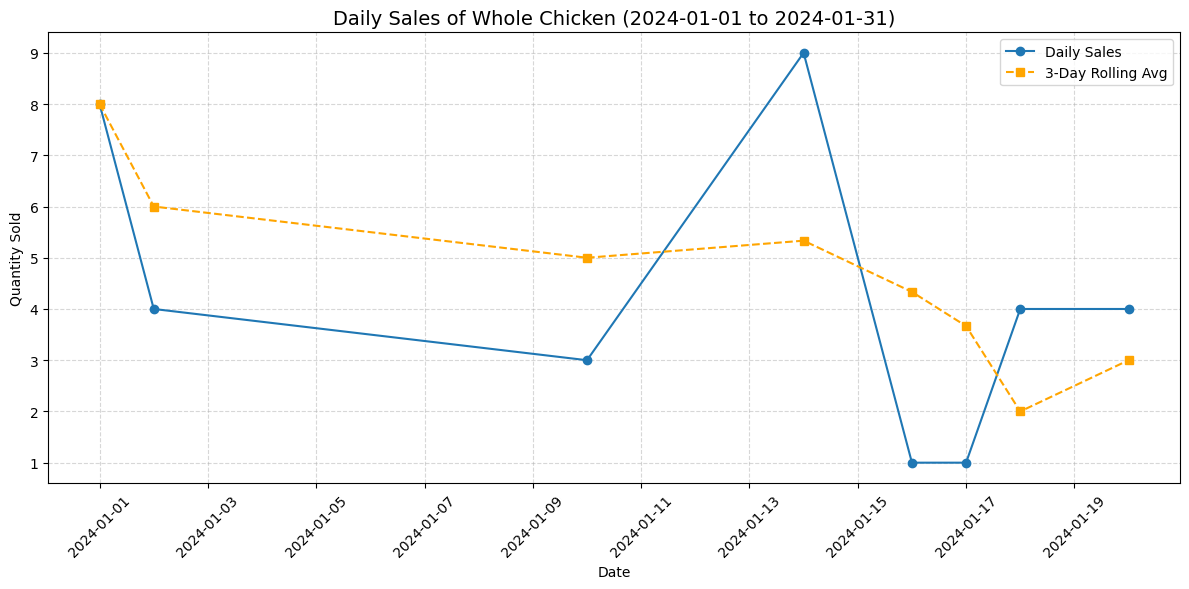

In [36]:
user_input = {
    "start_date": "2024-01-01",
    "end_date": "2024-01-31",
    "product_name": "Whole Chicken"
}

result = get_product_sales_summary(user_input)

# Convert daily_sales to DataFrame for plotting
daily_sales_df = pd.DataFrame(result["daily_sales"])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_df["buying_date"], daily_sales_df["quantity"], marker='o', label="Daily Sales")
plt.plot(daily_sales_df["buying_date"], daily_sales_df["rolling_avg"], marker='s', linestyle='--', color='orange', label="3-Day Rolling Avg")

plt.title(f"Daily Sales of {result['product_name']} ({result['start_date']} to {result['end_date']})", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# **Chart For Religion Based Sales Pattern**

In [37]:
def get_sales_summary_by_product_and_religion(user_input: dict):
    # Convert input dates to datetime
    start_date = pd.to_datetime(user_input["start_date"], errors="coerce")
    end_date = pd.to_datetime(user_input["end_date"], errors="coerce")

    # Filter sales by date
    filtered_sales = sales_data[
        (sales_data["buying_date"] >= start_date) &
        (sales_data["buying_date"] <= end_date)
    ]

    if filtered_sales.empty:
        return {
            "start_date": user_input["start_date"],
            "end_date": user_input["end_date"],
            "message": "No sales data found",
            "products": []
        }

    # Group by product and religion
    grouped = (
        filtered_sales.groupby(["product_name", "customer_religion"])["quantity"]
        .sum()
        .unstack(fill_value=0)
    )

    # Convert to JSON-like list
    products_summary = []
    for product, row in grouped.iterrows():
        products_summary.append({
            "product_name": product,
            "sales_by_religion": row.to_dict(),
            "total_quantity": int(row.sum())
        })

    return {
        "start_date": user_input["start_date"],
        "end_date": user_input["end_date"],
        "products": products_summary
    }

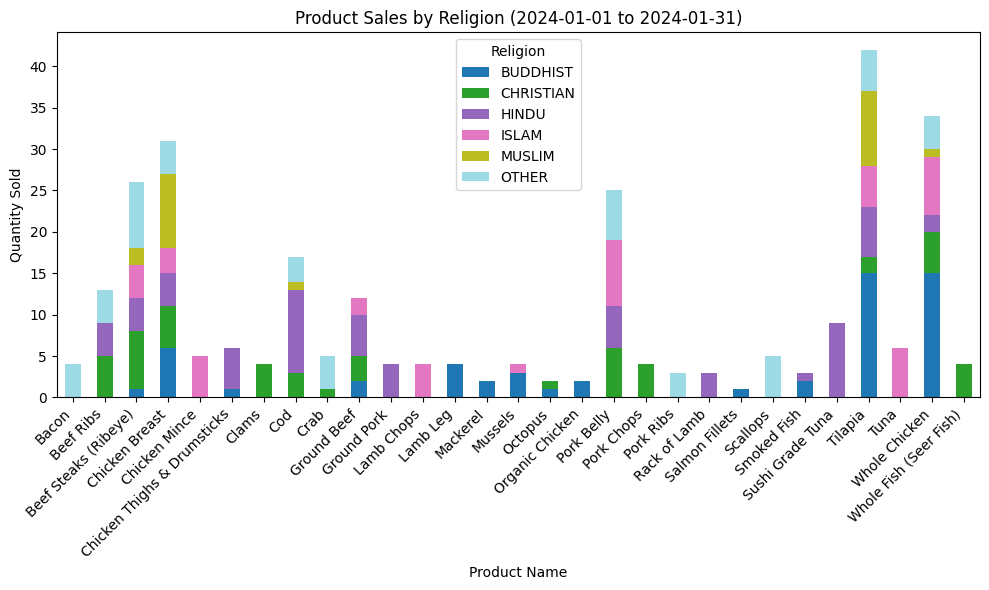

In [38]:
user_input = {
    "start_date": "2024-01-01",
    "end_date": "2024-01-31"
}

result_json = get_sales_summary_by_product_and_religion(user_input)
df_list = []
for product in result_json["products"]:
    product_name = product["product_name"]
    for religion, qty in product["sales_by_religion"].items():
        df_list.append({
            "product_name": product_name,
            "religion": religion,
            "quantity": qty
        })

df = pd.DataFrame(df_list)

# Pivot for stacked bar chart
pivot_df = df.pivot(index="product_name", columns="religion", values="quantity").fillna(0)

# Plot stacked bar chart
pivot_df.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20")

plt.title(f"Product Sales by Religion ({user_input['start_date']} to {user_input['end_date']})")
plt.xlabel("Product Name")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Religion")
plt.tight_layout()
plt.show()

# **Chart For Province Based Sales Pattern**

In [39]:
def get_sales_summary_by_group(user_input, group_by="religion"):
    # Filter by date
    start_date = pd.to_datetime(user_input["start_date"])
    end_date = pd.to_datetime(user_input["end_date"])

    filtered = sales_data[
        (sales_data["buying_date"] >= start_date) &
        (sales_data["buying_date"] <= end_date)
    ]

    # Group and summarize
    summary = []
    for product, group in filtered.groupby("product_name"):
        sales_by_group = group.groupby(group_by)["quantity"].sum().to_dict()
        summary.append({
            "product_name": product,
            f"sales_by_{group_by}": sales_by_group
        })

    return {"products": summary}



def plot_stacked_chart(summary_json, group_by="religion", user_input=None):
    # Flatten data into DataFrame
    df_list = []
    for product in summary_json["products"]:
        product_name = product["product_name"]
        for group_value, qty in product[f"sales_by_{group_by}"].items():
            df_list.append({
                "product_name": product_name,
                group_by: group_value,
                "quantity": qty
            })

    df = pd.DataFrame(df_list)

    # Pivot for stacked bar chart
    pivot_df = df.pivot(index="product_name", columns=group_by, values="quantity").fillna(0)

    # Plot stacked bar chart
    pivot_df.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")

    title_suffix = ""
    if user_input:
        title_suffix = f" ({user_input['start_date']} to {user_input['end_date']})"

    plt.title(f"Product Sales by {group_by.capitalize()}{title_suffix}")
    plt.xlabel("Product Name")
    plt.ylabel("Quantity Sold")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title=group_by.capitalize())
    plt.tight_layout()
    plt.show()


{'products': [{'product_name': 'Bacon', 'sales_by_province': {'Northern': 4}}, {'product_name': 'Beef Ribs', 'sales_by_province': {'Central': 4, 'Sabaragamuwa': 9}}, {'product_name': 'Beef Steaks (Ribeye)', 'sales_by_province': {'Central': 2, 'Eastern': 7, 'North Western': 1, 'Southern': 10, 'Western': 6}}, {'product_name': 'Chicken Breast', 'sales_by_province': {'Central': 3, 'Northern': 6, 'Southern': 9, 'Western': 13}}, {'product_name': 'Chicken Mince', 'sales_by_province': {'Uva': 5}}, {'product_name': 'Chicken Thighs & Drumsticks', 'sales_by_province': {'Sabaragamuwa': 5, 'Western': 1}}, {'product_name': 'Clams', 'sales_by_province': {'Sabaragamuwa': 3, 'Uva': 1}}, {'product_name': 'Cod', 'sales_by_province': {'Central': 9, 'North Central': 3, 'Southern': 2, 'Western': 3}}, {'product_name': 'Crab', 'sales_by_province': {'Central': 1, 'North Western': 4}}, {'product_name': 'Ground Beef', 'sales_by_province': {'Central': 6, 'Eastern': 2, 'Northern': 1, 'Southern': 1, 'Western': 2}},

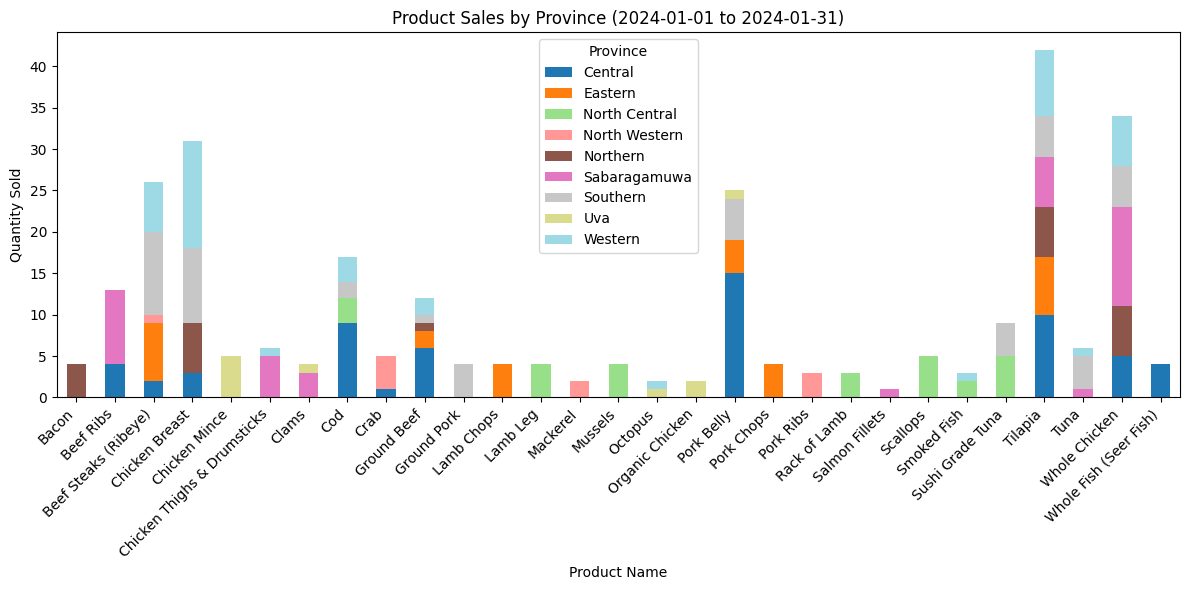

In [40]:
summary_province = get_sales_summary_by_group(user_input, group_by="province")
print(summary_province)
plot_stacked_chart(summary_province, group_by="province", user_input=user_input)